In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm.notebook import tqdm
import gym
from collections import deque
import random
import copy
import subprocess
import matplotlib.pyplot as plt
from PongEnv import PongEnv
from torchsummary import summary
import gc


try:
    from inf581 import *
except ModuleNotFoundError:
    process = subprocess.Popen("pip install nnfigs inf581".split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())
    from inf581 import *

from inf581.lab7 import *


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

env = PongEnv(render_mode='rgb_array')
observation_space = env.observation_space.shape
action_space = env.action_space.n

In [3]:
#observation_space = env.observation_space.shape
#action_space = env.action_space.n
EPISODES = 500
LR = 1e-3
MEM_SIZE = 2
BATCH_SIZE = 32
GAMMA = 0.95
EXPLORATION_MAX = 1.0
EXPLORATION_DECAY = 0.99999
EXPLORATION_MIN = 0.001
sync_freq = 10

In [4]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.action_space = action_space
        self.input_shape = observation_space

        self.loss = nn.MSELoss()
        print(self.input_shape)

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 6, kernel_size = 5)
        self.conv3 = nn.Conv2d(in_channels = 6, out_channels = 6, kernel_size = 5)
        self.linear1 = nn.Linear(2268,128)
        self.linear2 = nn.Linear(128,128)
        self.linear3 = nn.Linear(128,self.action_space)
        self.flatten = nn.Flatten()

        self.optimizer = optim.Adam(self.parameters(), lr=LR)
    
    def forward(self,x):
        x = x.permute((0,3,1,2))
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size = 3)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size = 3)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size = 3)
        x = self.flatten(x)
    
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [5]:
class ReplayBuffer:
    def __init__(self):
        self.memory = deque(maxlen=MEM_SIZE)
    
    def add(self, experience):
        self.memory.append(experience)
    
    def sample(self):
        minibatch = random.sample(self.memory, BATCH_SIZE)

        state1_batch = torch.stack([s1 for (s1,a,r,s2,d) in minibatch])
        action_batch = torch.tensor([a for (s1,a,r,s2,d) in minibatch])
        reward_batch = torch.tensor([r for (s1,a,r,s2,d) in minibatch])
        state2_batch = torch.stack([s2 for (s1,a,r,s2,d) in minibatch])
        done_batch = torch.tensor([d for (s1,a,r,s2,d) in minibatch])

        return (state1_batch, action_batch, reward_batch, state2_batch, done_batch)

In [6]:
class DQN:
    def __init__(self):
        self.replay = ReplayBuffer()
        self.exploration_rate = EXPLORATION_MAX
        self.network = Network().to(device)
        self.network2 = copy.deepcopy(self.network) #A
        self.network2.load_state_dict(self.network.state_dict())
        self.prev_action = 0
        self.time_prev_action = 5

    def choose_action(self, observation):
        self.time_prev_action +=1
        if self.time_prev_action < 5:
            return self.prev_action
        self.time_prev_action = 0
        if random.random() < self.exploration_rate:
            action = env.action_space.sample()
            self.prev_action = action
            return action

        # Convert observation to PyTorch Tensor
        state = torch.tensor(observation).float().detach()
        state = state.unsqueeze(0).to(device)
        
        q_values = self.network(state).to(device)

        # Choose the action to play
        action = torch.argmax(q_values).item()
        self.prev_action = action

        return action


    def learn(self):
        if len(self.replay.memory)< BATCH_SIZE:
            return 0


        # Sample minibatch s1, a1, r1, s1', done_1, ... , sn, an, rn, sn', done_n
        state1_batch, action_batch, reward_batch, state2_batch, done_batch = self.replay.sample()
        state1_batch = state1_batch.to(device)
        action_batch = action_batch.to(device)
        reward_batch = reward_batch.to(device)
        state2_batch = state2_batch.to(device)
        done_batch = done_batch.to(device)



        # Compute Q values
        q_values = self.network(state1_batch).squeeze()
        q_values = q_values.to(device)

        with torch.no_grad():
            # Compute next Q values
            next_q_values = self.network2(state2_batch).squeeze()
            next_q_values = next_q_values.to(device)

        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)

        predicted_value_of_now = q_values[batch_indices, action_batch].to(device)
        predicted_value_of_future = torch.max(next_q_values, dim=1)[0].to(device)

        # Compute the q_target
        q_target = reward_batch + GAMMA * predicted_value_of_future * (1-(done_batch).long())
        q_target = q_target.to(device)

        # Compute the loss (c.f. self.network.loss())
        loss = self.network.loss(q_target, predicted_value_of_now)


        # Complute 𝛁Q
        self.network.optimizer.zero_grad()
        loss.backward()
        self.network.optimizer.step()

        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)
        return loss.item()

    def returning_epsilon(self):
        return self.exploration_rate

(700, 300, 3)


  0%|          | 0/999 [00:00<?, ?it/s]

/tmp/ipykernel_982787/3722424645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).float()


Best score: 11
Episode 100 Average Reward 0.27 Best Reward 11 Last Reward 1 Epsilon 1.0


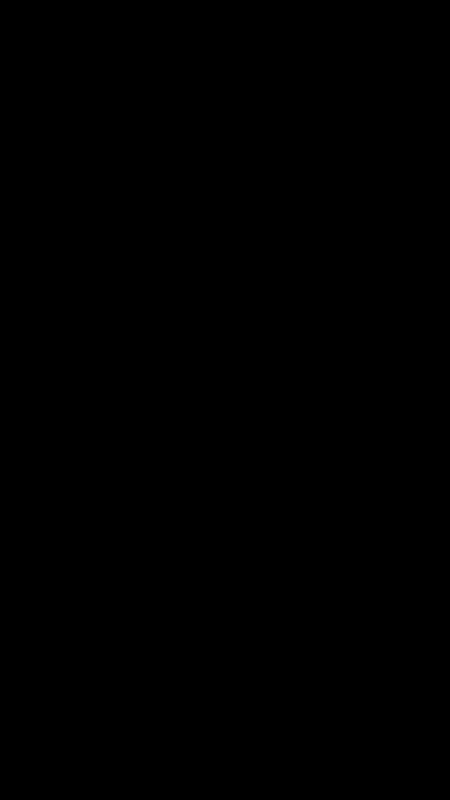

Episode 200 Average Reward 0.31 Best Reward 11 Last Reward 1 Epsilon 1.0


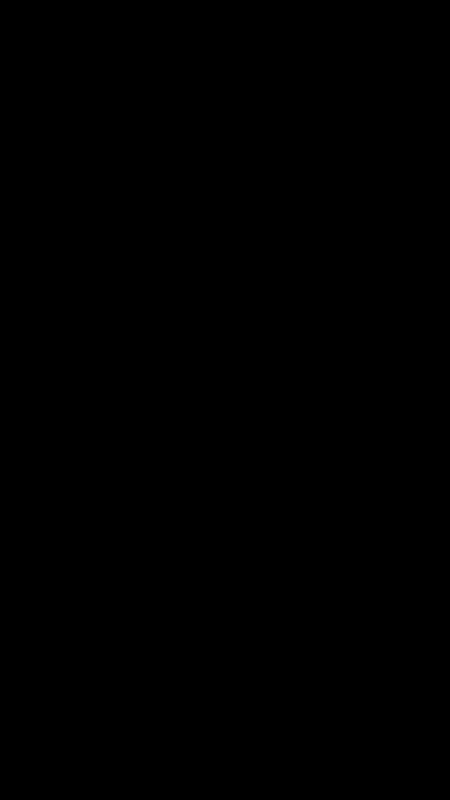

Episode 300 Average Reward 0.3 Best Reward 11 Last Reward 0 Epsilon 1.0


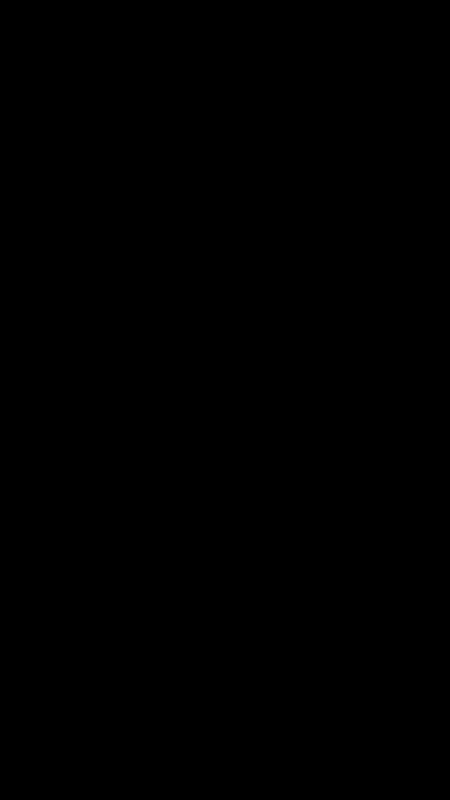

Best score: 36
Episode 400 Average Reward 0.4125 Best Reward 36 Last Reward 0 Epsilon 1.0


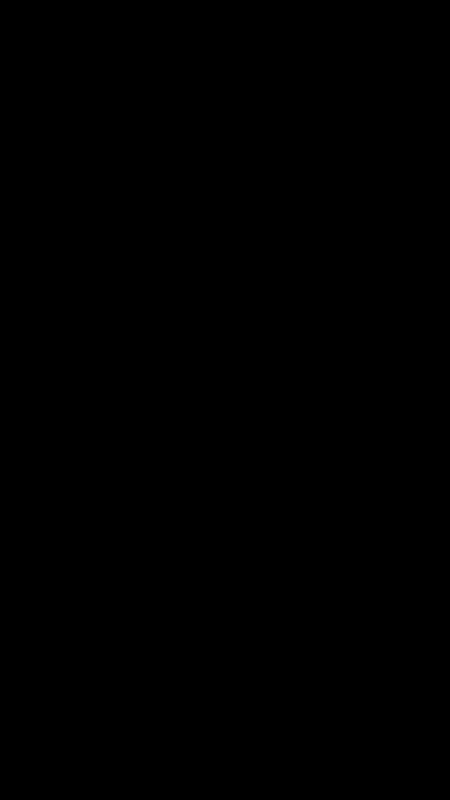

Episode 500 Average Reward 0.416 Best Reward 36 Last Reward 7 Epsilon 1.0


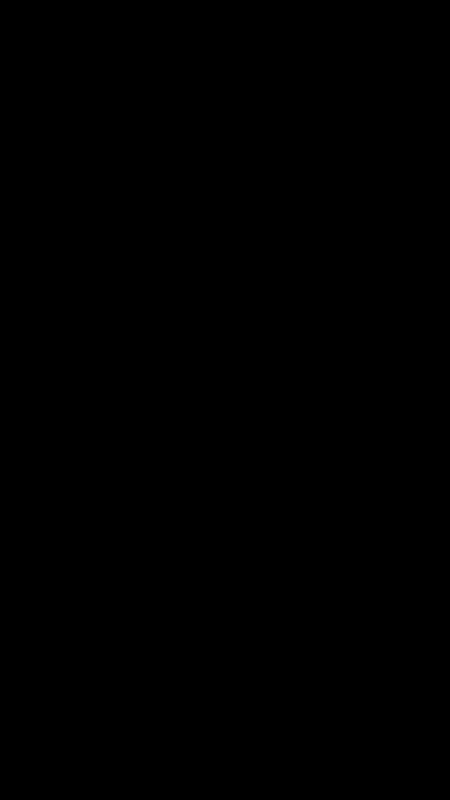

KeyboardInterrupt: 

In [7]:
agent = DQN()
EPISODES = 1000
best_reward = 0
average_reward = 0
episode_number = []
average_reward_number = []
gif_frequency = 100
j=0
loss_values = []
for i in tqdm(range(1, EPISODES)):
    k=0
    loss=0
    state,_ = env.reset()
    RenderWrapper.register(env, force_gif=True)
    score = 0

    while True:
        j+=1
        k+=1
        action = agent.choose_action(state)
        if i % gif_frequency == 0:
            env.render_wrapper.render()
        state_, reward, done, truncated,info = env.step(action)
        state = torch.tensor(state).float()
        state_ = torch.tensor(state_).float()

        exp = (state.to(device), action, reward, state_.to(device), done)
        agent.replay.add(exp)
        loss += agent.learn()

        state = state_
        score += reward

        if j % sync_freq == 0:
            agent.network2.load_state_dict(agent.network.state_dict())

        if done:
            if score > best_reward:
                best_reward = score
                if best_reward > 2 :
                    print(f'Best score: {best_reward}')
                    #display(env.render_wrapper.make_gif("best_score"))
            average_reward += score 
            
          
            if i % gif_frequency == 0:
                print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
                display(env.render_wrapper.make_gif("rl3_ex1left"))
  
                
            break
        loss_values.append(loss/k)
        episode_number.append(i)
        average_reward_number. append(average_reward/i)
    #gc.collect()
    #torch.cuda.empty_cache()

plt.plot(episode_number, average_reward_number)
plt.show()
plt.plot(episode_number,loss_values)
plt.show()

In [ ]:
env.observation_space.shape

In [ ]:
from torchsummary import summary


In [ ]:
model = Network().to(device)
summary(model,(800,450,3))

In [ ]:
observation_space

In [ ]:
env = gym.make("ALE/Pong-ram-v5")


In [ ]:
observation_space = env.observation_space.shape
observation_space

In [ ]:
env.render_wrapper.images

In [ ]:
print(env.render_mode)

In [ ]:
torch.cuda.empty_cache()